<a href="https://colab.research.google.com/github/iramosgarcia/emo-prediction/blob/master/CNN_ach4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN architecture 4

CNN architecture 4 proposed in paper:

title: Real-time Convolutional Neural Networks for Emotion and Gender Classification
      
link: https://github.com/oarriaga/face_classification/blob/master/report.pdf

In [0]:
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Input
from keras.layers import SeparableConv2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import layers
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

from keras.utils.np_utils import to_categorical
#from log import save_model, save_config, save_result
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(123)  # for reproducibility
from keras import backend as K
from keras.regularizers import l2

from sklearn.metrics import classification_report, confusion_matrix
from keras.models import load_model

import matplotlib.pyplot as plt
import matplotlib

Global variables

In [0]:
detected_emotions = ['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
emotions_values = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3,
           'Sad': 4, 'Surprise': 5, 'Neutral': 6}


batch_size = 256
nb_epoch   = 100
dropout    = 0.5
validation_split = 0.2

patience = 50

l2_regularization=0.01

Variable to specify whether you are running the model locally or using Colab

In [0]:
COLAB = True

Import datasets depending on the working enviroment. If colaboratory or not


In [0]:
# import datasets:
if (COLAB == False) :
  data_train_path = ['../../data/X_train_set.npy','../../data/y_train_set.npy']
  
else:
  !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
  !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
  !apt-get update -qq 2>&1 > /dev/null
  !apt-get -y install -qq google-drive-ocamlfuse fuse
  from google.colab import auth
  auth.authenticate_user()
  from oauth2client.client import GoogleCredentials
  creds = GoogleCredentials.get_application_default()
  import getpass
  !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
  vcode = getpass.getpass()
  !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
  
  
  !mkdir -p my_drive
  !google-drive-ocamlfuse my_drive
  
  data_train_path = ['./my_drive/TFM/Master_thesis/Modelos/data/X_train_set.npy','./my_drive/TFM/Master_thesis/Modelos/data/y_train_set.npy']
  data_test_path = ['./my_drive/TFM/Master_thesis/Modelos/data/X_test_set.npy','./my_drive/TFM/Master_thesis/Modelos/data/y_test_set.npy']
  

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110851 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
#Load training data
X_fname_train = data_train_path[0]
y_fname_train = data_train_path[1]
X_train = np.load(X_fname_train)
y_train = np.load(y_fname_train)

#Load testing data
X_fname_test = data_test_path[0]
y_fname_test = data_test_path[1]
X_test = np.load(X_fname_test)
y_test = np.load(y_fname_test)


In [0]:
X_train = X_train.astype('float32')
X_train /= 255  

X_test = X_test.astype('float32')
X_test /= 255 
     
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 48, 48)
    input_shape = (1, 48, 48)
else:
    X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
    input_shape = (48, 48, 1)

In [0]:
def architecture(in_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(shape =in_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
               # kernel_regularizer=regularization,
               padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax', name='predictions')(x)

    model = Model(img_input, output)
    return model



In [0]:
model = architecture(input_shape,y_train.shape[1],l2_regularization)
#Checkout of the summary
model.summary()

#Compile model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])




__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 46, 46, 8)    72          input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 46, 46, 8)    32          conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 46, 46, 8)    0           batch_normalization_29[0][0]     
__________________________________________________________________________________________________
conv2d_16 

In [0]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

Loading checkpoint just in casa an unexpected stopping

In [0]:
earlystop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1)

reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=int(patience/4), verbose=1)

filepath='./my_drive/TFM/Master_thesis/Modelos/checkpoints/weights'+str(batch_size)+'-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

  
callbacks_list = [earlystop,reduce_lr,checkpoint]  


  
print ('Training....')
#Training of the model

# fits the model on batches with real-time data augmentation:
history = model.fit_generator(data_generator.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs= nb_epoch,
                    verbose=1,
                    callbacks = callbacks_list,
                    validation_data= (X_test, y_test))

 

Training....
Epoch 1/100
 49/112 [============>.................] - ETA: 16s - loss: 1.3159 - acc: 0.5040

KeyboardInterrupt: ignored

In [0]:
# model result:
#evaluation of the model
print ('Testing....')
train_score = model.evaluate(X_train, y_train, verbose=0)
#print('Train loss:', train_score[0])
print('Train accuracy:', 100*train_score[1])
 
test_score = model.evaluate(X_test, y_test, verbose=0)
#print('Test loss:', test_score[0])
print('Test accuracy:', 100*test_score[1])
print ('Done!')


Testing....
('Train accuracy:', 70.86627886766941)
('Test accuracy:', 63.02591251127897)
Done!


In [0]:
#save the model trained

if (COLAB):
  model.save('./my_drive/TFM/Master_thesis/Modelos/CNN4-'+str(nb_epoch)+'epoch_'+str(batch_size)+'batchSize.h5') 
else:
  model.save('CNN4-'+str(nb_epoch)+'epoch_'+str(batch_size)+'batchSize.h5') 

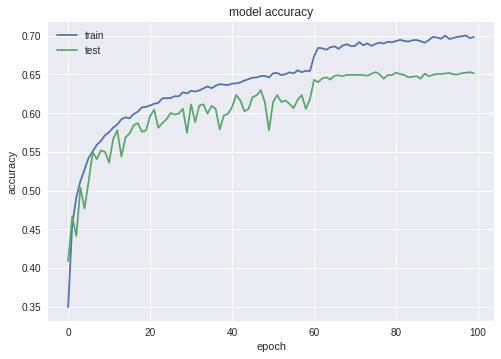

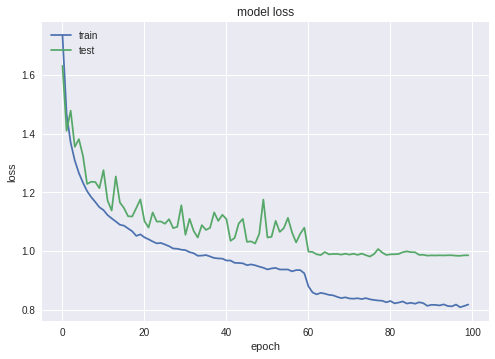

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Confusion matrix

In [0]:
model = load_model('./my_drive/TFM/Master_thesis/Modelos/CNN4-100epoch_32batchSize.h5')
predictions = model.predict(X_test)

y_pred = (predictions > 0.5)



In [0]:
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm

array([[ 711,    7,   49,   26,   67,   17,   81],
       [  59,   39,    1,    4,    6,    1,    1],
       [ 421,    3,  286,   14,  146,   76,   78],
       [ 177,    0,   14, 1463,   17,   27,   76],
       [ 501,    3,   54,   33,  495,   12,  149],
       [ 117,    0,   47,   34,    4,  621,    8],
       [ 357,    0,   18,   56,   90,   17,  695]])

In [0]:
labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

Text(0.5,38.926,u'Predicted label')

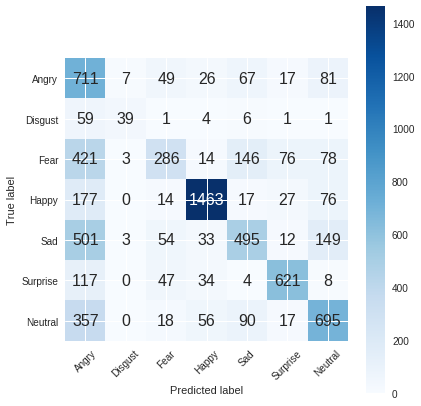

In [0]:
cmap=plt.cm.Blues
fig = plt.figure(figsize=(6,6))
matplotlib.rcParams.update({'font.size': 16})
ax  = fig.add_subplot(111)
matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
fig.colorbar(matrix) 
for i in range(0,7):
  for j in range(0,7):  
    if (cm[i,j] == 1463 ): 
       ax.text(j,i,cm[i,j],va='center',color='white', ha='center')
    else:
      ax.text(j,i,cm[i,j],va='center', ha='center')
    
# ax.set_title('Confusion Matrix')
ticks = np.arange(len(labels))
ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=45)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

##Attention maps

In [0]:
model = load_model('./my_drive/TFM/Master_thesis/Modelos/CNN4-100epoch_32batchSize.h5')

In [0]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations
from scipy import ndimage, misc

In [0]:
layer_idx = -1

In [0]:
 

X_test = X_test.astype('float32')
X_test /= 255 



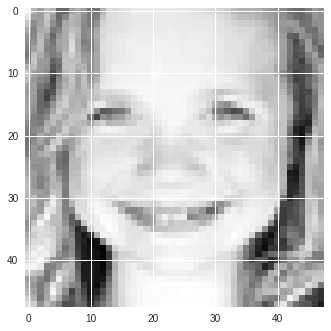

In [0]:
input_img = X_train[0:100,:,:,:] # subject0
plt.imshow(input_img[62,:,:,0], cmap='gray')
plt.show()



In [0]:
image = input_img[62]


image= image.astype('float32')
image /= 255 

image = image.reshape(1, 48, 48, 1)

image.shape

(1, 48, 48, 1)

In [0]:
class_idx = 1
for modifier in ['guided', None]:
    grads = visualize_saliency(model, layer_idx, filter_indices=class_idx,
                               seed_input=image, backprop_modifier=modifier)
    plt.figure()
    plt.title(modifier)
    plt.imshow(grads, cmap='jet')

InvalidArgumentError: ignored